In [1]:
import numpy as np
import pandas as pd
from collections import deque, defaultdict
import ast
import os
import glob
from pathlib import Path
from scipy.stats import mode
from modeling_parameters.config import (
    MATPLOTLIBRC_PATH,
    COORDINATES_PATH,
)

import matplotlib as mpl
mpl.rc_file(MATPLOTLIBRC_PATH)
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
import seaborn as sns

from functions import (
    add_distance_to_df,
    is_central_stations,
)

In [2]:
groups_df = pd.read_csv('groups_data/810-841_.csv')
groups_df['NEvent'] = groups_df['NEvent'].astype(int)

In [3]:
events_df = pd.read_parquet('../events.parquet', engine='pyarrow')
events_df = events_df.drop(columns=['Sdet'])

In [4]:
events_df.head(1)

,NRUN,NEvent,Theta,Phi,X0_opt,Y0_opt,Ne_opt,s_opt,loss,NtrackX,NtrackY,Ntrack,IdEv,Nview,worked_clusters,station_flags,rho,a_std,q_std,t_std
0,836,6627,63.67,116.71,33.168543,-80.0,5468.278104,1.441416,0.63366,6,6,5,0,7,"[2, 3, 4, 5, 6, 7, 8]","[False, False, False, False, True, True, False...","[0.5754942602040817, 0.22737962372448978, 0.39...","[None, None, None, None, 143.637, 88.789, None...","[None, None, None, None, 86.628, 34.227, None,...","[None, None, None, None, 2353.241, 2339.532, N..."


In [5]:
groups_df['NEvent'] = groups_df['NEvent'].astype(int)

events_df['NEvent'] = events_df['NEvent'].astype(int)

events_df = pd.merge(
    events_df,
    groups_df[['NEvent', 'Sdet']],
    on='NEvent',
    how='left'
)

In [6]:
events_df.head(1)

,NRUN,NEvent,Theta,Phi,X0_opt,Y0_opt,Ne_opt,s_opt,loss,NtrackX,...,Ntrack,IdEv,Nview,worked_clusters,station_flags,rho,a_std,q_std,t_std,Sdet
0,836,6627,63.67,116.71,33.168543,-80.0,5468.278104,1.441416,0.63366,6,...,5,0,7,"[2, 3, 4, 5, 6, 7, 8]","[False, False, False, False, True, True, False...","[0.5754942602040817, 0.22737962372448978, 0.39...","[None, None, None, None, 143.637, 88.789, None...","[None, None, None, None, 86.628, 34.227, None,...","[None, None, None, None, 2353.241, 2339.532, N...",28.4839


In [7]:
decor_dot = (5, 0, -11.5)
x_d, y_d, z_d = decor_dot
events_df = add_distance_to_df(events_df, decor_dot)

In [8]:
events_df['rho_mu'] = events_df['Nview'] / events_df['Sdet']

In [9]:
events_df.head(3)

,NRUN,NEvent,Theta,Phi,X0_opt,Y0_opt,Ne_opt,s_opt,loss,NtrackX,...,Nview,worked_clusters,station_flags,rho,a_std,q_std,t_std,Sdet,r_decor,rho_mu
0,836,6627,63.67,116.71,33.168543,-80.000,5468.278104,1.441416,0.633660,6,...,7,"[2, 3, 4, 5, 6, 7, 8]","[False, False, False, False, True, True, False...","[0.5754942602040817, 0.22737962372448978, 0.39...","[None, None, None, None, 143.637, 88.789, None...","[None, None, None, None, 86.628, 34.227, None,...","[None, None, None, None, 2353.241, 2339.532, N...",28.4839,48.827842,0.245753
1,836,12188,42.90,198.78,50.000000,80.000,90724.620406,2.000000,0.496810,17,...,15,"[3, 4, 5, 7, 9]","[False, False, False, False, False, False, Fal...","[0.30331898384353745, 0.4862218324829932, 0.03...","[None, None, None, None, None, None, None, Non...","[None, None, None, None, None, None, None, Non...","[None, None, None, None, None, None, None, Non...",26.5495,84.290791,0.564982
2,836,12453,51.32,212.71,-25.359000,5.885,15917.649306,1.961136,0.749836,6,...,6,"[1, 2, 3, 5, 8]","[True, True, True, True, True, True, True, Tru...","[0.9574829931972789, 0.171343537414966, 0.1644...","[247.509, 76.928, 85.595, 53.739, 21.248, 89.5...","[144.128, 25.792, 24.751, 20.768, 7.834, 42.13...","[2376.449, 2347.995, 2335.962, 2361.802, 2372....",30.8412,21.934734,0.194545


In [10]:
n = 2
events_df = events_df[events_df.apply(lambda row: is_central_stations(row, n), axis=1)]

In [11]:
events_df1 = events_df[
    (events_df['X0_opt'] > -20) & (events_df['X0_opt'] < 20) &
    (events_df['Y0_opt'] > -30) & (events_df['Y0_opt'] < 30) &
    (events_df['loss'] < 0.3)  &
     (events_df['r_decor'] < 15)
]

In [12]:
len(events_df1)

101

In [13]:
rho_mu = np.array(events_df1['rho_mu'])
r_decor = np.array(events_df1['r_decor'])

In [14]:
muon_df = pd.read_csv('rho_mu_corsika/s27pDAT000001_rho_m.txt', sep='\t', header=None)
muon_df.columns = ['r', 'rho', 's']

r_corsika = np.array(10 ** muon_df['r'])
rho_corsika = np.array(muon_df['rho'])

mask = r_corsika < 3e2
r_corsika = r_corsika[mask]
rho_corsika = rho_corsika[mask]


In [15]:
df = pd.DataFrame({'r_decor': r_decor, 'rho_mu': rho_mu})

bins = np.arange(1, df['r_decor'].max() + 1, 2)
df['r_bin'] = pd.cut(df['r_decor'], bins)
grouped = df.groupby('r_bin', observed=True)['rho_mu'].median().reset_index()


r_centers = [interval.mid for interval in grouped['r_bin']]
grouped.drop('r_bin', axis=1, inplace=True)
grouped['r'] = r_centers

In [16]:
grouped.head()


,rho_mu,r
0,0.342126,2.0
1,0.241992,4.0
2,0.237393,6.0
3,0.208869,8.0
4,0.212363,10.0


In [17]:
grouped.to_csv('rho_events', index=False, sep=",", header=('rho', 'r'))

In [ ]:
events_rho_mu_df = pd.read_csv('rho_events')
r = events_rho_mu_df['r']
rho = events_rho_mu_df['rho']
std = grouped['std']
muons_df = pd.DataFrame({'r': r, 'rho': rho, 'std': std})
muons_df.to_csv('r_rho_std', index=False, sep=",", header=('r', 'rho', 'std'))

In [49]:
events_rho_mu_df = pd.read_csv('r_rho_std')
r = events_rho_mu_df['r']
rho = events_rho_mu_df['rho']
std = events_rho_mu_df['std']

In [50]:
events_rho_mu_df.head()

,r,rho,std
0,2.0,0.342126,0.14671
1,4.0,0.248540,0.12916
2,6.0,0.241992,0.14261
3,8.0,0.237393,0.15975
4,10.0,0.231314,0.12049


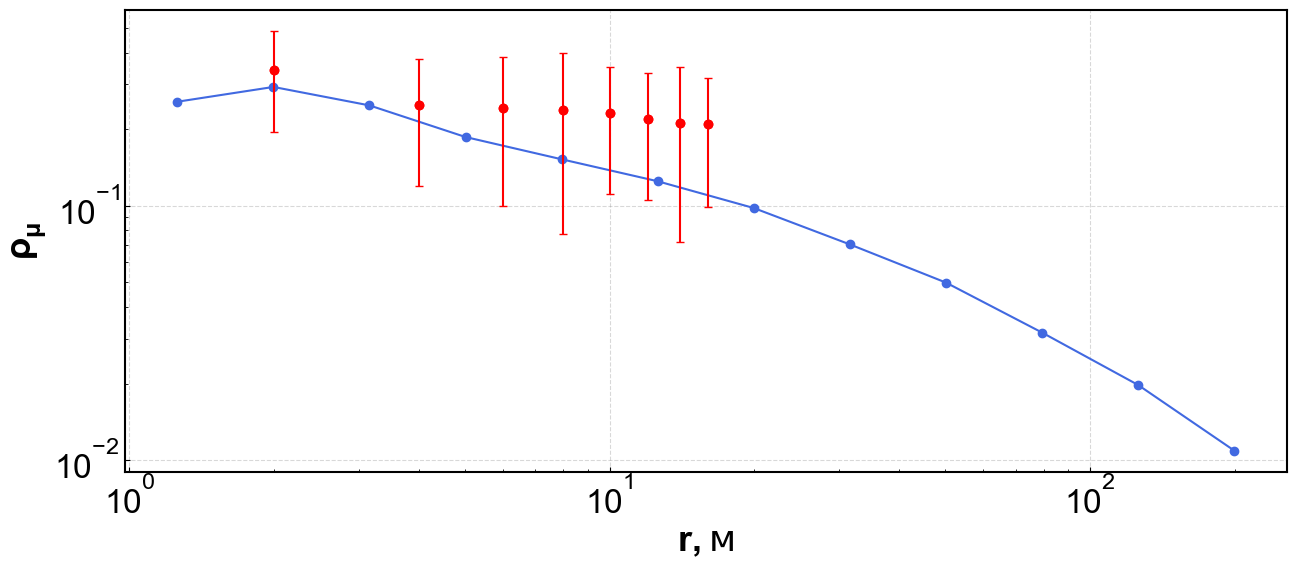

In [51]:
plt.figure(figsize=(15, 6))

plt.plot(r_corsika, rho_corsika, marker='o', color='royalblue')
# plt.scatter(r_decor, rho_mu, color='red')
# plt.scatter(bin_centers, median_rho_mu, color='red', label='Median ρμ in bins')
# plt.scatter(events_rho_mu_df['r'], events_rho_mu_df['rho'], marker='o', color='red')
plt.scatter(r, rho, marker='o', color='red')
plt.errorbar(r, rho, yerr=std, fmt='o', capsize=3, color='red')

plt.xlabel(r'$r,\text{м}$')
plt.ylabel(r'$\rho_{\mu}$')
plt.yscale('log')
plt.xscale('log')
plt.grid()
plt.show()

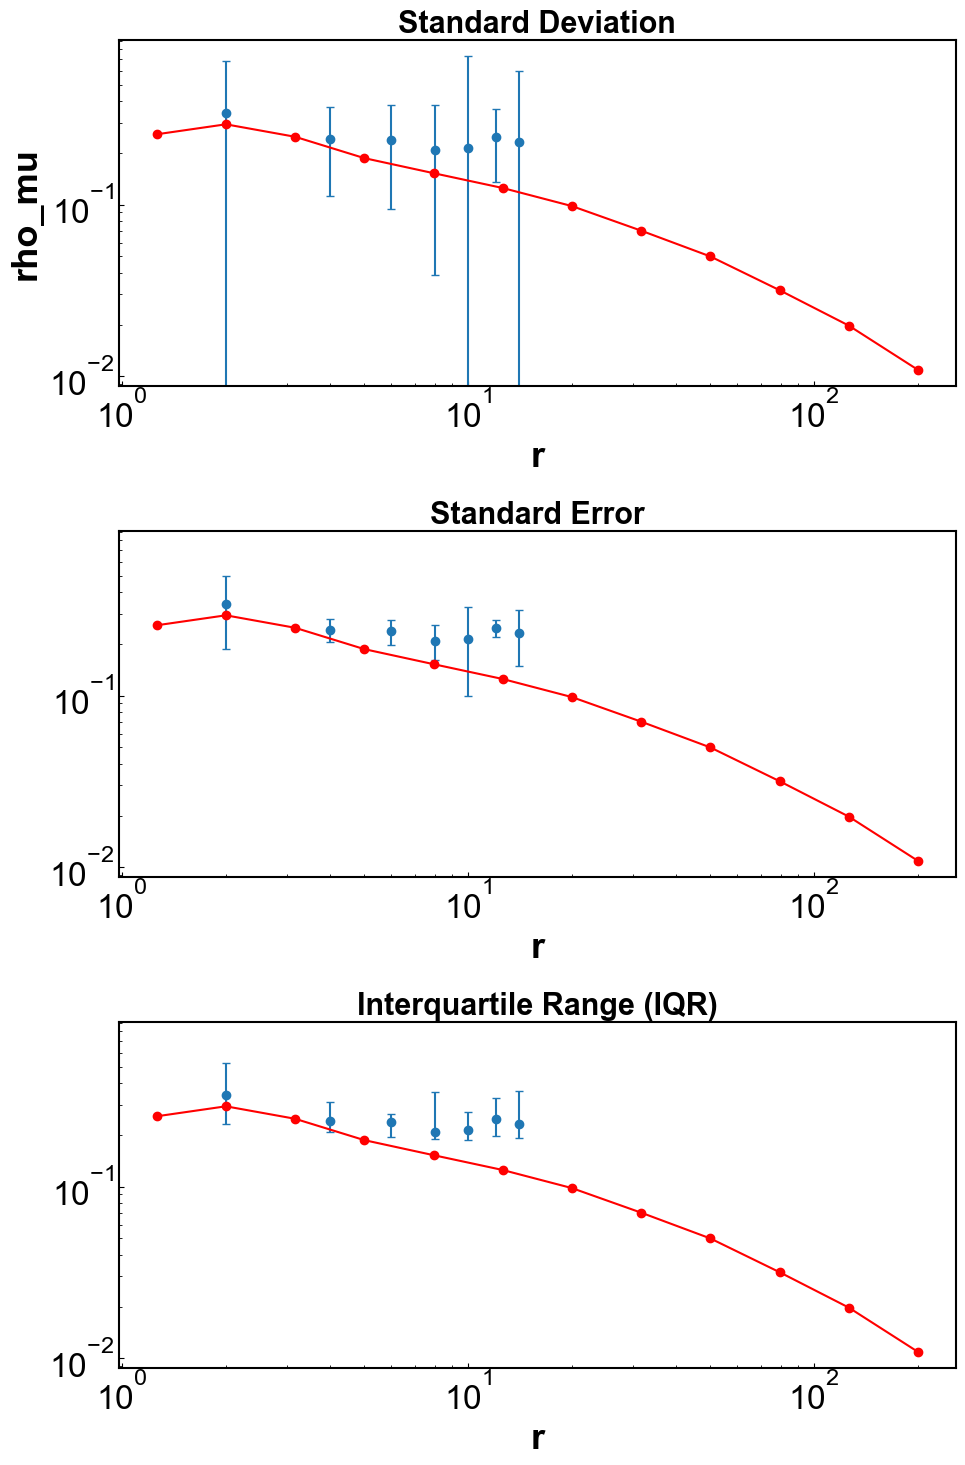

In [28]:
# Группировка
grouped = df.groupby('r_bin', observed=True)['rho_mu'].agg(
    median='median',
    mean='mean',
    std='std',
    count='count',
    q25=lambda x: np.percentile(x, 25),
    q75=lambda x: np.percentile(x, 75)
).reset_index()

# Центры биннов
r_centers = [interval.mid for interval in grouped['r_bin']]
grouped['r'] = r_centers

# Стандартная ошибка
grouped['stderr'] = grouped['std'] / np.sqrt(grouped['count'])

# Межквартильный размах
grouped['iqr'] = grouped['q75'] - grouped['q25']
grouped['iqr_err_low'] = grouped['median'] - grouped['q25']
grouped['iqr_err_high'] = grouped['q75'] - grouped['median']

# === ГРАФИКИ ===
fig, axs = plt.subplots(3, 1, figsize=(10, 15), sharey=True)

# 1. Стандартное отклонение
axs[0].errorbar(grouped['r'], grouped['median'], yerr=grouped['std'],
                fmt='o', capsize=3)
axs[0].plot(r_corsika, rho_corsika, marker='o', color='red')
axs[0].set_title('Standard Deviation')
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlabel('r')
axs[0].set_ylabel('rho_mu')

# 2. Стандартная ошибка
axs[1].errorbar(grouped['r'], grouped['median'], yerr=grouped['stderr'],
                fmt='o', capsize=3)
axs[1].plot(r_corsika, rho_corsika, marker='o', color='red')
axs[1].set_title('Standard Error')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlabel('r')

# 3. Межквартильный размах (асимметричная ошибка)
axs[2].errorbar(grouped['r'], grouped['median'],
                yerr=[grouped['iqr_err_low'], grouped['iqr_err_high']],
                fmt='o', capsize=3)
axs[2].plot(r_corsika, rho_corsika, marker='o', color='red')
axs[2].set_title('Interquartile Range (IQR)')
axs[2].set_xscale('log')
axs[2].set_yscale('log')
axs[2].set_xlabel('r')

plt.tight_layout()
plt.show()


In [29]:
grouped.head()

,r_bin,median,mean,std,count,q25,q75,r,stderr,iqr,iqr_err_low,iqr_err_high
0,"(1.0, 3.0]",0.342126,0.454047,0.346717,5,0.231759,0.525389,2.0,0.155057,0.293631,0.110367,0.183263
1,"(3.0, 5.0]",0.241992,0.296139,0.129170,13,0.209017,0.312546,4.0,0.035825,0.103529,0.032975,0.070554
2,"(5.0, 7.0]",0.237393,0.282972,0.142619,13,0.193305,0.264632,6.0,0.039555,0.071326,0.044087,0.027239
3,"(7.0, 9.0]",0.208869,0.291486,0.169758,13,0.188550,0.355330,8.0,0.047082,0.166780,0.020320,0.146461
4,"(9.0, 11.0]",0.212363,0.366606,0.520497,21,0.186678,0.273425,10.0,0.113582,0.086747,0.025685,0.061061


In [54]:
not_events = pd.read_csv('not_events.csv')
not_events.head()

,_id,NRUN,NEvent,NtrackX,NtrackY,Ntrack,Theta,Phi,IdEv,Nview
0,670924948e40c45e657994bb,821,11359,6,6,6,65.57,215.33,0,6
1,670924948e40c45e657994c4,821,91052,5,5,5,50.11,237.14,0,5
2,670924948e40c45e657994c5,821,96289,6,5,4,47.80,244.14,0,6
3,670924948e40c45e657994d1,821,154481,9,10,9,60.38,201.84,0,6
4,670924948e40c45e657994d7,821,203537,5,4,4,43.01,213.69,0,5


In [57]:
len(not_events)

1394

In [55]:
not_events_theta = np.array(not_events['Theta'])
not_events_count = np.array(not_events['Nview'])

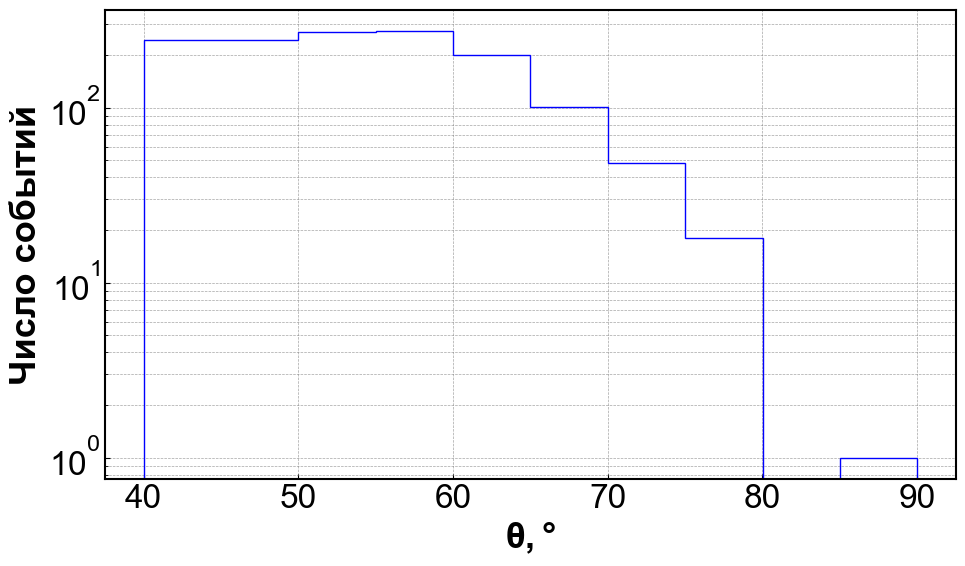

In [66]:
bin_width = 5
min_theta = min(not_events_theta)
max_theta = max(not_events_theta)

bins = np.arange(min_theta, max_theta + bin_width, bin_width)

plt.figure(figsize=(10, 6))
counts, bins, _ = plt.hist(not_events_theta, bins=bins, histtype='step', color='blue', log=True)

plt.xlabel(r'$\theta, \degree$')
plt.ylabel('Число событий')
plt.yscale('log')
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

In [71]:
mask = not_events_theta < 55
muons = not_events_count[mask]

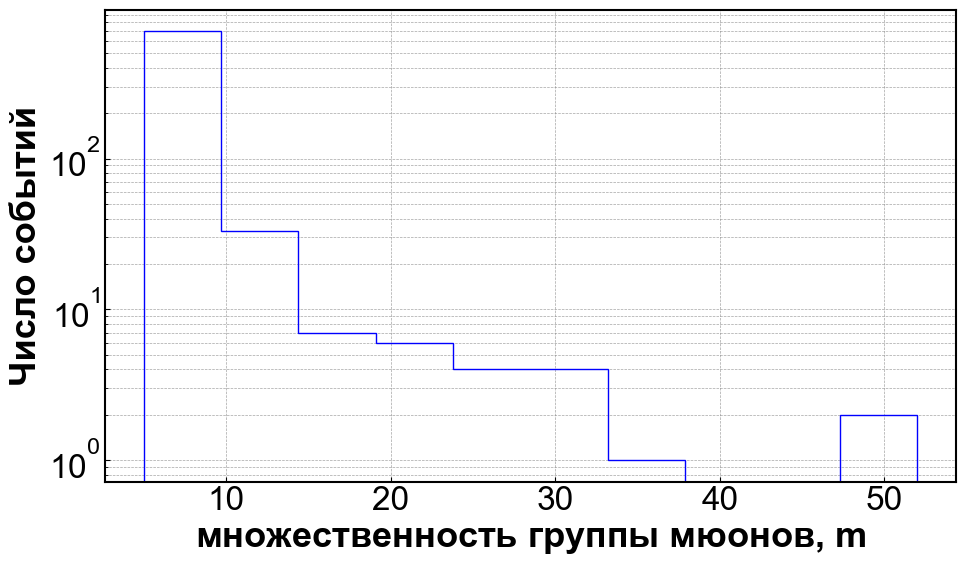

In [72]:
bins = 10 

plt.figure(figsize=(10, 6))
counts, bins, _ = plt.hist(muons, bins=bins, histtype='step', color='blue', log=True)

plt.xlabel(r'множественность группы мюонов, $m$')
plt.ylabel('Число событий')
plt.yscale('log')
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()